<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#" data-toc-modified-id="-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" alt=""></a></span><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#ARIMA" data-toc-modified-id="ARIMA-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>ARIMA</a></span></li></ul></li><li><span><a href="#Model-evaluation-&amp;-summary" data-toc-modified-id="Model-evaluation-&amp;-summary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model evaluation &amp; summary</a></span></li><li><span><a href="#Business-analysis" data-toc-modified-id="Business-analysis-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Business analysis</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Reference</a></span></li></ul></li></ul></div>

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

## Modeling

In [1]:
# Import libraries
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from datetime import datetime
from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# We are required to do this in order to avoid "FutureWarning" issues.
register_matplotlib_converters()
sns.set_style(style='darkgrid')

In [2]:
# Reading in the dataset
df = pd.read_csv('./data/data_eda.csv')

In [3]:
# Creating a new column to record rooms sold for the day
df['rooms_sold'] = 1

In [4]:
# Creating a new dataframe for modeling
modeldf = pd.DataFrame(df.groupby('ck_in_dt')['rooms_sold'].sum())

In [5]:
# Confirm.
modeldf.head()

,rooms_sold
ck_in_dt,
2012-07-02,4
2012-07-03,12
2012-07-04,12
2012-07-05,21
2012-07-06,43


In [6]:
modeldf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417 entries, 2012-07-02 to 2013-08-22
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   rooms_sold  417 non-null    int64
dtypes: int64(1)
memory usage: 6.5+ KB


### ARIMA

**To fit an ARIMA model, we need to specify 3 parameters: p, d and q**

We need to make sure our Time Series is stationary before modeling it. If our Time Series is stationary, we will use the original data, if it is not, we will difference it. Differenced data often is stationary so we will difference it once and twice and test for stationarity.

In [7]:
# Create first_diff_room and second_diff_room
# columns in df.
modeldf['first_diff_room'] = modeldf['rooms_sold'].diff(1)
modeldf['second_diff_room'] = modeldf['rooms_sold'].diff(1).diff(1)

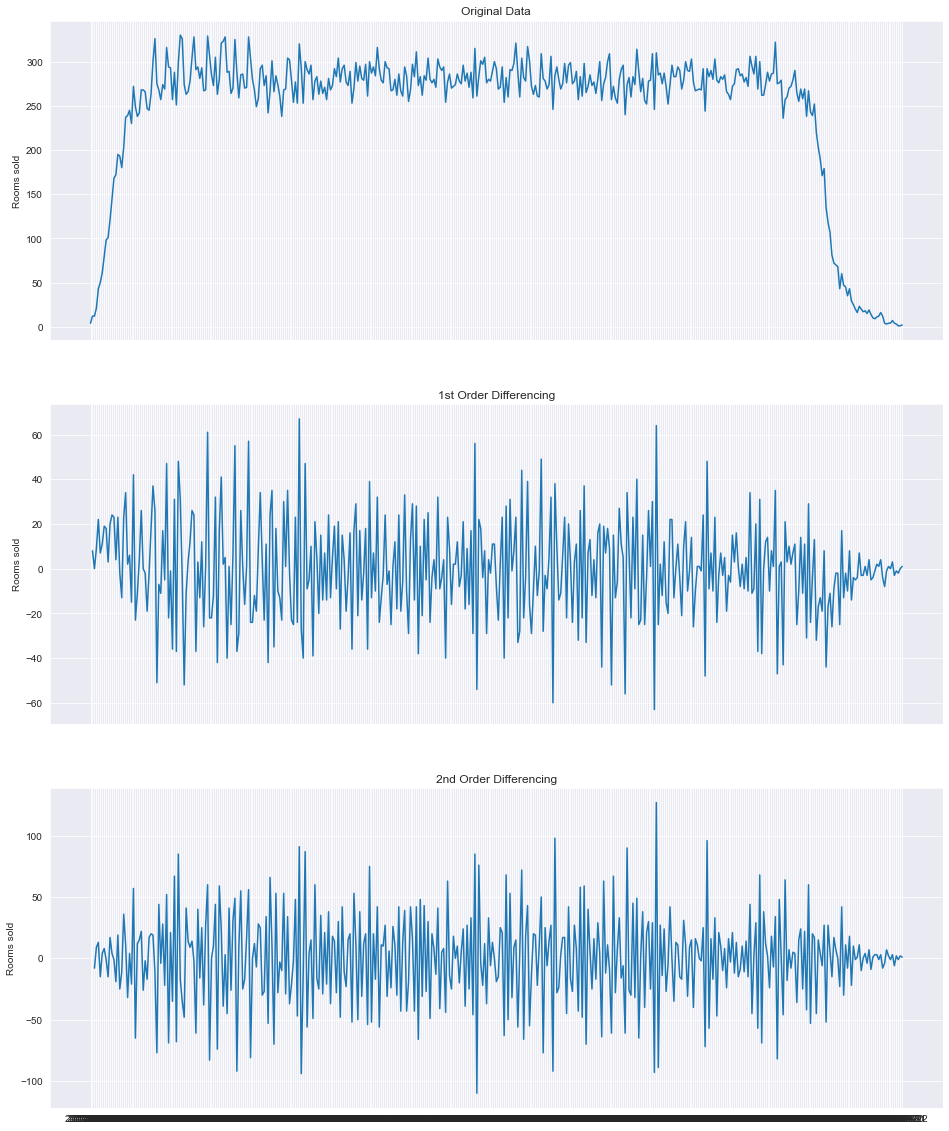

In [8]:
# Generate time plots of our data.
fig, axes = plt.subplots(3, sharex=True, figsize=(16, 20))

# Original data
axes[0].plot(modeldf.rooms_sold)
axes[0].set_title('Original Data')
axes[0].set_ylabel('Rooms sold')

# 1st Differencing
axes[1].plot(modeldf.first_diff_room)
axes[1].set_title('1st Order Differencing')
axes[1].set_ylabel('Rooms sold')

# 2nd Differencing
axes[2].plot(modeldf.second_diff_room)
axes[2].set_title('2nd Order Differencing')
axes[2].set_ylabel('Rooms sold')

plt.show()

In [9]:
# Code modified from code written by Joseph Nelson.
# Ho = It is not stationary
# Ha = It is stationary

def interpret_dftest(dftest):
    # display only 2 components from the test
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    print(dfoutput)  # print test results
    if dfoutput[1] <= 0.01:  # define alpha as 0.01
        print('Strong evidence to reject the null hypothesis (Ho), data is stationary')
    else:
        print('Weak evidence against null hypothesis (Ho), data is not stationary')

**Testing for stationarity**

In [10]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(modeldf['rooms_sold']))

Test Statistic   -0.618613
p-value           0.866721
dtype: float64
Weak evidence against null hypothesis (Ho), data is not stationary


In [11]:
# Run the ADF test on our once-differenced data.
interpret_dftest(adfuller(modeldf['first_diff_room'].dropna()))

Test Statistic   -4.532614
p-value           0.000172
dtype: float64
Strong evidence to reject the null hypothesis (Ho), data is stationary


**With p-value less than 0.01, we have strong evidence to reject the null hypothesis and accept that the once differenced data is stationary**

In [12]:
# Checking our dataset
pd.options.display.max_rows = 500
modeldf

,rooms_sold,first_diff_room,second_diff_room
ck_in_dt,,,
2012-07-02,4,NaN,NaN
2012-07-03,12,8.0,NaN
2012-07-04,12,0.0,-8.0
2012-07-05,21,9.0,9.0
2012-07-06,43,22.0,13.0
2012-07-07,50,7.0,-15.0
2012-07-08,61,11.0,4.0
2012-07-09,80,19.0,8.0
2012-07-10,98,18.0,-1.0


**Once we have determined the value for d, we can proceed with the modeling**

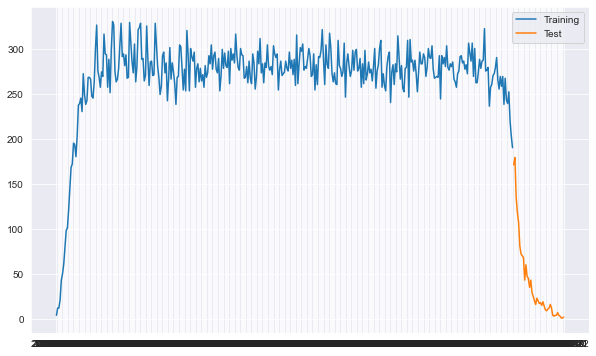

In [47]:
# Splitting the data into train/test with test size of 0.1
y_train1, y_test1 = train_test_split(
    modeldf['rooms_sold'], test_size=0.1, shuffle=False)

plt.figure(figsize=(10, 6))
plt.plot(y_train1, label='Training')
plt.plot(y_test1, label='Test')
plt.legend(loc='best')
plt.show()

In [48]:
# Setting up auto arima to grid search for 
# and fit a model with the best parameters
model = auto_arima(y_train1, 
                   start_p=1, d=1, start_q=1, # start value of p and q, d is fixed at 1
                   max_p=5, max_q=5,  # maximum p and q
                   m=1,              # frequency of series
                   seasonal=False,   # no seasonality
                   trace=True,       # print status on fit
                   error_action='warn', # warn when error
                   suppress_warnings=True, # not print warnings from arima statsmodel
                   stepwise=False) # fit all hyperparameters combinations

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3415.900, Time=2.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3322.954, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3324.508, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3326.506, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3324.809, Time=0.41 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3351.406, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3324.511, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3326.508, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3328.468, Time=0.72 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3293.868, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3338.006, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3326.500, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3328.504, Time=0.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3324.627, Time=0.90 sec
 ARIMA(3,1,0)(0

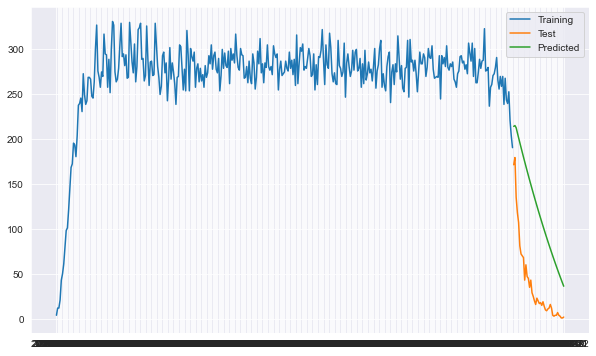

In [49]:
# Create a dataframe for predictions
prediction = pd.DataFrame(model.predict(n_periods=len(
    y_test1)), index=y_test1.index, columns=['Prediction'])

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_train1, label='Training')
plt.plot(y_test1, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc='best')
plt.show()

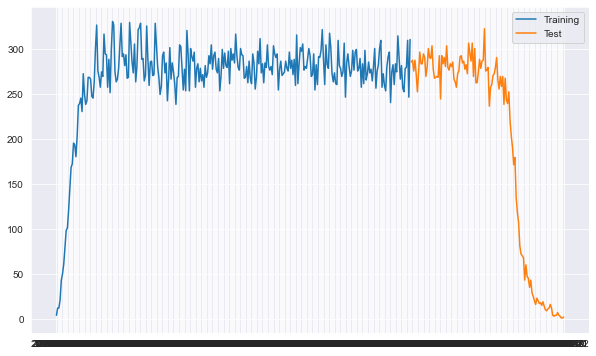

In [50]:
# Splitting the data into train/test with test size of 0.3
y_train3, y_test3 = train_test_split(
    modeldf['rooms_sold'], test_size=0.3, shuffle=False)

plt.figure(figsize=(10, 6))
plt.plot(y_train3, label='Training')
plt.plot(y_test3, label='Test')
plt.legend(loc='best')
plt.show()

In [51]:
# Setting up auto arima to grid search for 
# and fit a model with the best parameters
model = auto_arima(y_train3, 
                   start_p=1, d=1, start_q=1, # start value of p and q, d is fixed at 1
                   max_p=5, max_q=5,  # maximum p and q
                   m=1,              # frequency of series
                   seasonal=False,   # no seasonality
                   trace=True,       # print status on fit
                   error_action='warn', # warn when error
                   suppress_warnings=True, # not print warnings from arima statsmodel
                   stepwise=False) # fit all hyperparameters combinations

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2676.132, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2605.055, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2606.400, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2608.198, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2600.728, Time=0.35 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2590.352, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2630.563, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2606.453, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2608.358, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2610.336, Time=0.48 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2586.576, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2618.897, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2608.164, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2610.347, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(3,1,0)(0

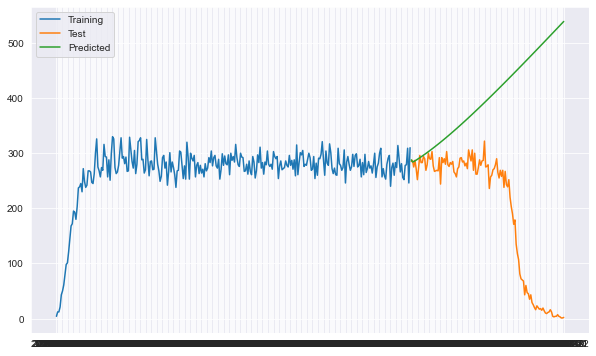

In [52]:
# Create a dataframe for predictions
prediction = pd.DataFrame(model.predict(n_periods=len(
    y_test3)), index=y_test3.index, columns=['Prediction'])

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_train3, label='Training')
plt.plot(y_test3, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc='best')
plt.show()

**Other than the 2 examples above, we did many trials with different splitting ratio of train and test sets and found that the first part (the climb) and the last part (the dip) heavily skewed the data and we decided to take the stabilized data after the climb and before the dip**

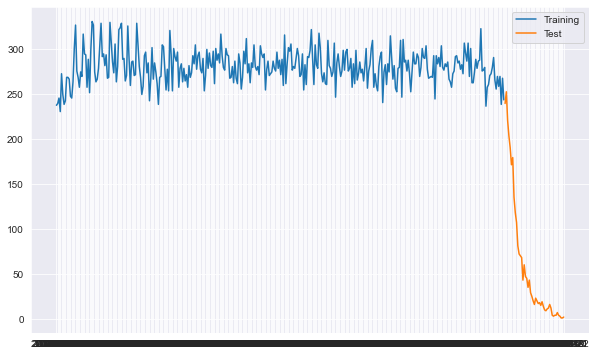

In [44]:
# Splitting the data into train/test 
train = modeldf['rooms_sold'][18:370]
test = modeldf['rooms_sold'][370:]

plt.figure(figsize=(10, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()

In [21]:
# Setting up auto arima to grid search for 
# and fit a model with the best parameters
model = auto_arima(train, 
                   start_p=1, d=1, start_q=1, # start value of p and q, d is fixed at 1
                   max_p=5, max_q=5,  # maximum p and q
                   m=1,              # frequency of series
                   seasonal=False,   # no seasonality
                   trace=True,       # print status on fit
                   error_action='warn', # warn when error
                   suppress_warnings=True, # not print warnings from arima statsmodel
                   stepwise=False) # fit all hyperparameters combinations

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3215.933, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3048.505, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3047.161, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3049.051, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3048.182, Time=0.46 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3045.115, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3144.419, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3047.155, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3049.131, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3045.070, Time=0.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3124.296, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3049.083, Time=0.49 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3050.089, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.871, Time=1.15 sec
 ARIMA(3,1,0)(0

**Ideally, the p-value for AR and MA should be close to zero and we have a both values at zero here so we can proceed with this model** 

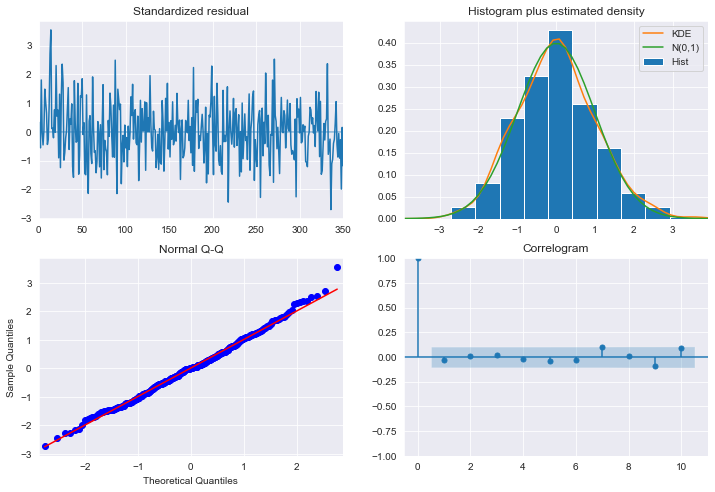

In [22]:
# Evaluate the model
model.plot_diagnostics(figsize=(12,8))
plt.show()

**Evaluating the model**
- Starting from top left diagram, the errors appears to fluctuate around 0 and have a uniform variance.
- Top right diagram shows a normal distribution with a mean of 0.
- In the bottom left diagram, all the dots fall on or very near to the red line with only 1 at the end falling a little far away but we expected that because of the nature of the data
- Finally, we see in the bottom right diagram that errors are not autocorrelated.
- In summary, this model appears to be a good fit.

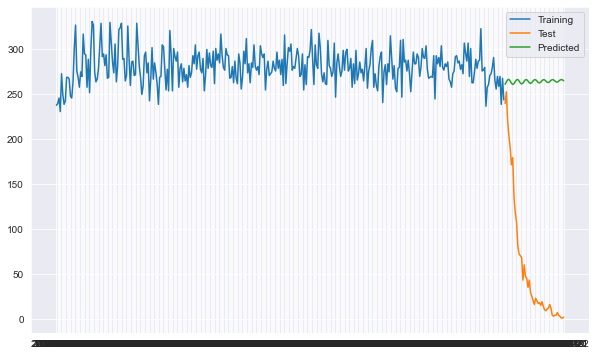

In [23]:
# Create a dataframe for predictions
prediction = pd.DataFrame(model.predict(n_periods=len(
    test)), index=test.index, columns=['Prediction'])

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc='best')
plt.show()

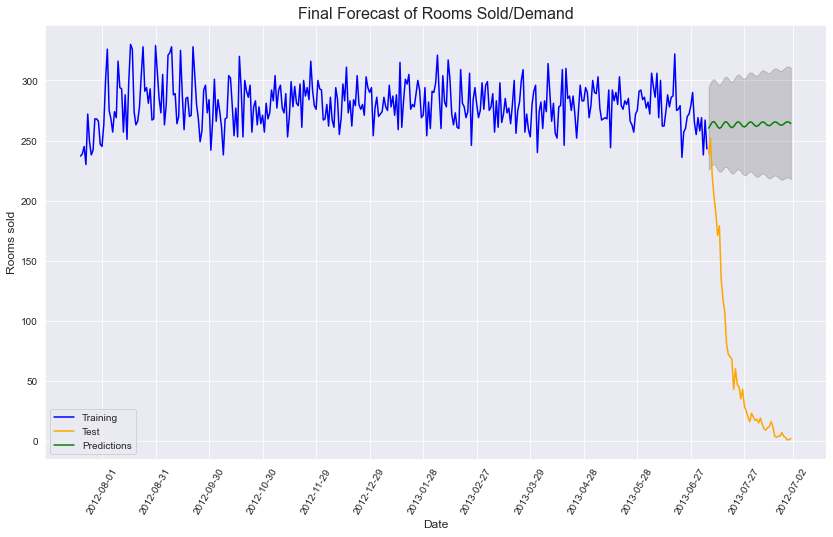

In [46]:
# Forecast
# Setting the period of forecast
n_periods = len(test)

# Construct confidence interval for the fitted parameters
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Setting index of forecast
index_of_fc = test.index 

# Create series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(14, 8))
plt.plot(train, color='blue', label='Training')
plt.plot(test, color='orange', label='Test')
plt.plot(fc_series, color='green', label='Predictions')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Rooms sold', fontsize=12)
plt.xticks(modeldf.index[::30], rotation=60)
plt.title("Final Forecast of Rooms Sold/Demand", fontsize=16)
plt.legend(loc='lower left')
plt.show()
# Code by Selva Prabhakaran

## Model evaluation & summary

For this analysis, we chose an ARIMA model to conduct a time series forecast to predict rooms sold/demand over a daily interval using the series past values. It is important to note that there is a steep climb at the first part and a sharp dip in the last part of this dataset. After many rounds of experimenting with different train/test split ratio, due to the nature of this particular dataset, we have come to the conclusion that the sharp increment/decrement in the data made it relatively unfriendly to conventional data science machine learning modeling. The machine tend to overfit on the training data and the predictions are heavily skewed. With that, we declare that a deployable model is not achievable. On that note, we do offer a model without the sharp increment/decrement in the data and to make a forecast as presented above with the green line as the prediction and the grey area as the 95% confidence interval where we are 95% confident that the prediction will fall within the range of the grey area. Given more time, we can train a SARIMAX model using exogenous features and/or a RNN model to make more forecasts. However, looking at the sharp dip in the demand to near zero, we concluded that efforts will be better spent on tackling the immediate emergency by conducting the business analysis and recommendations to revive the business.

## Business analysis

**Overview**


From the Power BI deck, we see that this analysis is conducted on a dataset over a period of approximately 14 months from July 2012 to August 2013. There are a total of 82 hotels operating in 23 cities across the nation China. The chain generated a total of 10.09m USD during this period, out of which 7.74m USD is from room revenue and the remainder from other sources like room service and spa etc. One thing we note is that the check in counts and revenue in each city stayed pretty consistent throughout this period with not much changes or sudden jumps which means the business is operationally stable.


**Metrics and rules**


For this analysis, we will be using check in counts and revenue as the metrics. We will also be employing the Pareto Principle, also known as the 80/20 rule, which asserts that, in our case, 80% of our revenue come from 20% of our product(hotel).


**Analysis by City**


Going by the Pareto Principal, we will focus in on the top 6 hotels (20% of 23 cities rounded up + 1 to cover a slightly wider range). We calculated the average total revenue per city to be around 439,000 USD and average check in count per city to be 4479. Top 6 Cities by total revenue are Shanghai, Hangzhou, Suzhou, Nanjing, Guangzhou and Jiuzhaigou and top 6 cities by check in count are basically the same top 5 but with Wuxi coming in at the 6th position. One reason why these cities are making it into the tables is because they have more hotels so generally it makes sense that more hotels means more check ins and higher revenue and that brings our attention to 5 cities: Jiuzhaigou and Wuxi for good reasons and Chengdu, Shenzhen and Chongqing for bad ones. 


With 2 hotels in the city, while Jiuzhaigou is 57% below the nation's average in check in counts, they did very well in bringing in revenue to rank at 6th. On the other hand, Wuxi, with only 1 hotel, while missing the total revenue average by around 29%, managed to boost a high check in count to rank, again, at 6th place. It is worth zooming into these 2 cities to find out more about how and what they have been doing to bring in good results like they have. 


According to the Chinese city tier system by Yicai global 2017, Shenzhen is a tier 1 city and Chengdu and Chongqing are new tier 1 (used to be tier 2 in the older system) cities. With 5 hotels and being a tier 1 city, it is worrying to see Shenzhen performing below nation's average in both metrics, specifically near 30% below for both. Similarly, being a new tier 1 city, with 6 hotels in Chengdu and 4 in Chongqing, these 2 cities disappointedly did 45 to 67% below average in both departments.


**Cities to focus**

| City          	| Reason                           	|
|----------------	|----------------------------------	|
| **Jiuzhaigou** 	| High revenue low check in counts 	|
| **Wuxi**       	| High check in counts low revenue 	|

| City          	| Reason                           	|
|---------------	|----------------------------------	|
| **Shenzhen**  	| Low in revenue & check in counts 	|
| **Chengdu**   	| Low in revenue & check in counts 	|
| **Chongqing** 	| Low in revenue & check in counts 	|

**Analysis by hotel**


Using the same 20% rule, we will focus in on the top 17 performing hotels. A simple comparison showed us that the top 17 hotels by total revenue are the same as the ones by check in counts which made perfect sense because these 2 metrics are closely correlated where most of the revenue are generated from selling rooms. All hotels except Suzhou City Rodman, Hangzhou Grand Jordan and Shanghai Grant V performed above national average on both metrics. Those 3 fared slightly below in the revenue section by between 7 to 40%. 


Having acknowledged the correlation between check in counts and revenue, there are two categories we are particularly interested in: low check in counts high revenue and high check in counts low revenue. In the first category, we have Shanghai Urban Pippen, Hanzhou Pippen, Shanghai East Rodman and Shanghai City Pippen. These 5 hotels brought in relatively high revenue with a comparatively low check in counts. 2 points of interest may be how they managed that and also how to increase the check in counts.


In the second category we have Guangzhou Urban Jordan, Shanghai Grant I and Wuxi Pippen. Likewise from the previous category, it would be interesting to find out why these 3 hotels are generating relatively low revenue when so many rooms were sold and also on the positive end, dive deeper into how they managed to sell so many rooms.


**Hotels to focus**

| Revenue below average     	|
|---------------------------	|
| **Suzhou City Rodman**    	|
| **Hangzhou Grand Jordan** 	|
| **Shanghai Grant V**      	|

| Low check in counts high revenue 	|
|----------------------------------	|
| **Shanghai Urban Pippen**        	|
| **Hangzhou Pippen**              	|
| **Shanghai East Rodman**         	|
| **Shanghai City Pippen**         	|

| High check in counts low revenue 	|
|----------------------------------	|
| **Guangzhou Urban Jordan**       	|
| **Shanghai Grant I**             	|
| **Wuxi Pippen**                  	|

**Analysis by member**


We generated a Decomposition Tree on the page Revenue decomposition to provide some analysis by members. Using this tree, we can drill down from city to individual hotel to every member who have stayed there and which city they are from. This can be useful for the Sales & marketing team for target precision marketing purpose. It is also shown that our chain is generating 75% of revenue from Platinum members and the remaining 25% from gold members,  as well as 68% from tier 1, 31% from tier 2 and less than 1% of revenue from tier 3 members. This is good evidence that our loyalty program 'The Staycation Card' is working well and we should work and further capitalize on it.


**The decline**

Addressing the sudden and sharp dip in check in counts starting from July 2013, we went ahead to conduct some research and found two possibilities.
- 2013 Southwest flood
- Xi Jinping's ascension to power

In July 2013, much of southwest China experienced heavy rainfall that led to widespread flooding. Sichuan was the hardest hit. An estimated 6 million lives were disrupted by the floods. Following that, typhoons and storms made landfall over China devastating northern, northeastern and southern provinces affecting, in total, an estimated 72 million lives. As we can see on our deck, that is EXACTLY how our hotels are distributed across the country. This natural disaster probably single handedly destroyed the sales during this period forcing most, if not all of bookings to be canceled. 


The second reason could be due to Xi Jinping's ascension to power in March 2013. Upon taking office, Xi launched a far reaching campaign against corruption where he outlined the 'eight-point guide' listing rules intended to curb corruption and waste during official party business including traveling only when necessary and reducing entourage to bare minimum. The campaign immediately went into strict enforcement causing many booked trips to be canceled or reduced in size. While we understand that our group is focused more on staycation than business traveling market, this was a major event during that time which hugely affected hotel industry. Even if it did not have a direct impact on us, there could still be some degree of indirect effect.

**Recommendations**


While it is impossible to control natural disasters, we can
1. Change marketing tactics
- Storms and typhoons are mostly seasonal and weather stations usually issue warnings before they happen. While dealing with a natural disaster, we can avoid waste in marketing by pausing marketing campaigns, replacing regular email campaigns with messages crafted for an emergency and anticipate cancellations.
2. Regulate updates
- We can maximize our social media platforms to offer updates to guests, concerned parties and community and keep guests and interested parties notified on the progress of the events.
3. Recovery
- Ensuring safety of guests and employees should be primary concern. If possible, keep track of any damages during the event to better formulate cleanup plans and focus on recovery after the event for reopening.
4. Diversification
- To prevent being affected too much by a certain group (in this case, business travelers), we can diversify and target different market groups like family or couple so we are not dependent on any specific groups.


## Reference

- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://en.wikipedia.org/wiki/2013_Southwest_China_floods
- https://www.chinacheckup.com/blogs/articles/chinese-financial-year
- https://en.wikipedia.org/wiki/Chinese_city_tier_system
- http://crashcoursemba.com/what-is-the-80-20-rule-in-business/
- https://www.hospitalitynet.org/opinion/4091797.html